# Лабораторная работа 4.7.2

#### Эффект Поккельса

### Библиотеки 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import math as m
import random as r

from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.integrate import quad

In [2]:
def Line(x, a, b):
    """
    Параметрическая прямая
    """
    return a*x + b

#-----------------------------------------------------------------------------------------------------------
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ВНИМАНИЕ !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
# Тупой питон не может подставить знак минус перед коэффициентом b! Если экспонента имеет вид e(^b), b < 0,
# то минус надо указать вручную.
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
#-----------------------------------------------------------------------------------------------------------
def Exponent(x, a, b, c):
    """
    Параметрическая експонента (ae^(bx)
    """
    return a * np.exp(-b * x) + c

def CalcErrors(popt, cov, precA = 4, precB = 4, printRes = True):
    """
    Вычисляет погрешность МНК.
    Выводит в консоль значения + погрешность.
    Возвращает массив погрешностей.
    """
    errors = []
    for i in range(len(popt)):
        try:
          errors.append(np.absolute(cov[i][i])**0.5)
        except:
          errors.append( 0.00 )
    errors = np.array(errors)

    if (printRes == True):
        for i in range(0, len(errors)):
            print("c{:d} = {:.0{prec}f} +- {:.0{prec}f}".format(i + 1, popt[i], errors[i], prec = precA))

    return errors

def NpToStrList(np_array, precision):
    np_array = np.around(np_array.astype(float), precision)

    return ["{:.0{prec}f}".format(val, prec = precision) for val in np_array]

def NpToStr(array):
    return [str(f) for f in array]

def PrintMinMax(array, header):
    print(header + "min = {:.3f}, max = {:.3f}".format(min(array), max(array)))
    
#jnb.HideCell()

In [3]:
def _getIndex(indexRow, indexColumn, isRowDataSet):
    """
    Возвращает индексы в правильном порядке для обращения к массиву.
    """
    if (isRowDataSet == True):
        return (indexRow, indexColumn)
    else:
        return (indexColumn, indexRow)

def _drawRowGrid(file, rowGrid, rowIndex):
    if (rowGrid != None and rowGrid[rowIndex] > 0):
         file.write("\\hline\n" * rowGrid[rowIndex])

def _getTableDim(data, isRowDataSet):
    if (isRowDataSet == True):
        return (len(data), len(data[0]))
    else:
        return (len(data[0]), len(data))

def _createTable(fileName, data, isRowDataSet, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу, если rowDataSet == false и горизонтальную, если rowDataSet == true.

    Аргументы:
    fileName     - имя выходного файла с таблицей;
    data         - массив данных таблицы;
    isRowDataSet - если true, массив данных содержит горизонтальную таблицу, иначе вертикальную;
    columnGrid   - строка, которая определяет тип сетки между колонками: \begin{tabular}{columnGrid};
    rowGrid      - список длины rowCount + 1, в котором содержится число:
                        - 0 - нет       горизонтальной линии;
                        - 1 - одинарная горизонтальная линия;
                        - 2 - двойная   горизонтальная линия.
    """
    rowCount, columnCount = _getTableDim(data, isRowDataSet)

    with open("tables\\" + fileName, 'w', encoding='utf-8') as file:

        if (columnGrid == None):
            columnGrid = "|" + 'c|' * columnCount
        
        file.write("\\begin{tabular}[t]{" + columnGrid +"}\n")

        _drawRowGrid(file, rowGrid, 0)
        
        if (preheader != None):
            file.write(preheader)

        for rowIndex in range(0, rowCount):

            for colIndex in range(0, columnCount - 1):
                index1, index2 = _getIndex(rowIndex, colIndex, isRowDataSet)

                file.write("{} & ".format(str(data[index1][index2]).replace('.', ',')))

            index1, index2 = _getIndex(rowIndex, columnCount - 1, isRowDataSet)

            file.write("{} \\\\ \n".format(str(data[index1][index2]).replace('.', ',')))

            _drawRowGrid(file, rowGrid, rowIndex + 1)

        # End data draw cycle
        file.write('\end{tabular}')

def CreateVerticalTable(fileName, data, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, data, False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateVerticalTableHeader(fileName, header, dataColumns, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, [[header[st]] + dataColumns[st] for st in range(0, len(dataColumns))],
                                False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateHorizontalTable(fileName, dataRows, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт горизонтальную Latex-таблицу.
    """
    _createTable(fileName, dataRows, True, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)
    

### Обработка результатов измерений

In [10]:
n = np.array([1,    2,    3,    4,    5,    6   ])
r = np.array([27.5, 39.5, 49.5, 56.5, 63.5, 70.5])

sig_r = 0.5 * m.sqrt(2) / 2
r2 = r*r
sig_r2 = 2 * r * sig_r
print(sig_r)

popt1, pcov1 = curve_fit(Line, n, r2)
print(r2)

errs2 = CalcErrors(popt1, pcov1)

a2 = popt1[0]
eps_a2 = errs2[0] / a2

lambd = 630 * 10**-6
n_o = 2.29
L = 800
sig_L = 5
eps_L = sig_L / L
l = 26
delta_n = lambd * (n_o * L) ** 2 / (a2 * l)
eps_delta_n = (4 * eps_L**2 + eps_a2**2)**0.5
sig_delta_n = eps_delta_n * delta_n

print("n_o - n_e = {:.3f} +- {:.3f}. eps = {:.1f}%".format(delta_n, sig_delta_n, eps_delta_n * 100))

0.3535533905932738
[ 756.25 1560.25 2450.25 3192.25 4032.25 4970.25]
c1 = 835.0857 +- 12.0799
c2 = -95.8834 +- 47.0445
n_o - n_e = 0.097 +- 0.002. eps = 1.9%


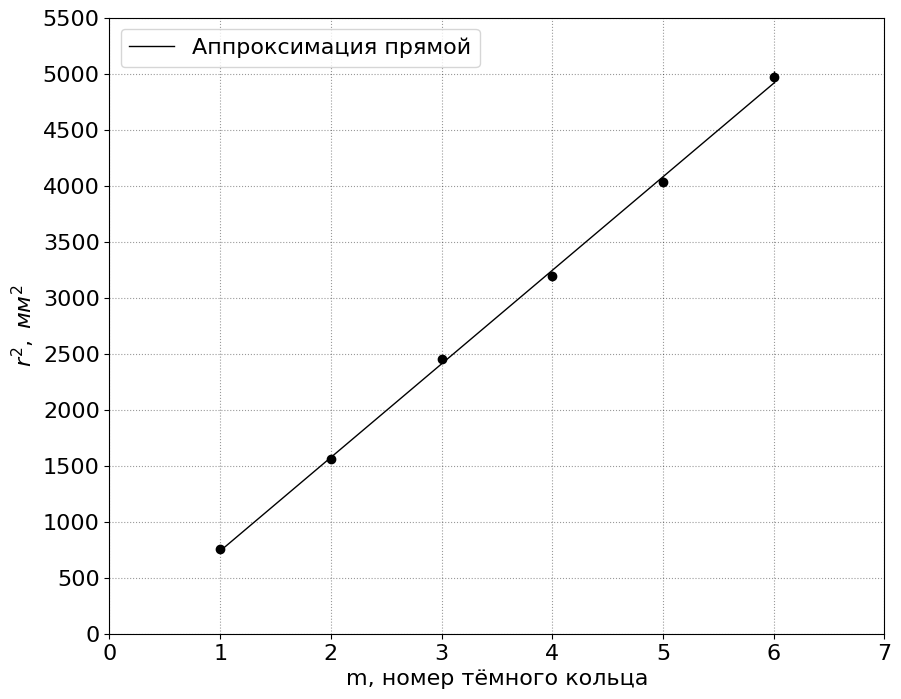

In [14]:
xMin = 0
xMax = 7.001

yMin = 0
yMax = 5500.01

xLabel          = r'm, номер тёмного кольца'
yLabel          = r'$r^2, \; мм^2$'

xMinorStep      = 0
xMajorStep      = 1

yMinorStep      = 0
yMajorStep      = 500

xTickMultiplier = 1
yTickMultiplier = 1

xPrecision      = 0
yPrecision      = 0

# Построение графика.

mpl.rcParams['font.size'] = 16

fig  = plt.figure(figsize = (10,8), dpi = 100)
axes = fig.add_subplot()

fig.set_facecolor("white")

# Заголовок

plt.xlabel(xLabel)
plt.ylabel(yLabel)

# Линии
plt.errorbar(n, r2, yerr = sig_r2, xerr = 0, fmt = 'o', linewidth = 1, color = 'black')

plt.plot(n, Line(n, *popt1), linewidth = 1, color = 'black', label = r'Аппроксимация прямой')

# Оформление масштабных чёрточек

if yMajorStep > 0:
    y_major_ticks = np.arange(yMin, yMax, yMajorStep)
    axes.set_yticks(y_major_ticks)

if yMinorStep > 0:
    y_minor_ticks = np.arange(yMin, yMax, yMinorStep)
    axes.set_yticks(y_minor_ticks, minor = True)

if xMajorStep > 0:
    x_major_ticks = np.arange(xMin, xMax, xMajorStep)
    axes.set_xticks(x_major_ticks)

if xMinorStep > 0:
    x_minor_ticks = np.arange(xMin, xMax, xMinorStep)
    axes.set_xticks(x_minor_ticks, minor = True)

# Пределы графика

plt.xlim([xMin, xMax])
plt.ylim([yMin, yMax])

# Форматирование чёрточек

def xTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * xTickMultiplier, prec = xPrecision).replace('.', ',')

def yTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * yTickMultiplier, prec = yPrecision).replace('.', ',')

axes.xaxis.set_major_formatter(ticker.FuncFormatter(xTickFormatter))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(yTickFormatter))

# Легенда
plt.legend(loc = 'upper left')

# Сетка
plt.grid(which='major', linestyle = ':', c = 'black', alpha = 0.4)
plt.grid(which='minor', linestyle = ':', c = 'black', alpha = 0.1)

# Вывод
plt.savefig("Графики/r2(m).png")
plt.show()

In [39]:
Udel = 15 # 1 del = 15 V
sigU = Udel / 2

n2 = np.array([0, 1,   2,   3,    4])
U2 = np.array([0, 270, 630, 1020, 1380])
n3 = np.array([0, 1, 2, 3])
U3 = np.array([0, 240, 630, 1110])

popt2, pcov2 = curve_fit(Line, n2, U2)
popt3, pcov3 = curve_fit(Line, n3, U3)

CalcErrors(popt2, pcov2)
CalcErrors(popt3, pcov3)

U = 351 # В
sig_U = 12
d = 3   # мм
print(lambd)
A = lambd * d / (4 * U * l)
#   мм * мм / (В * мм)
A /= 1000 # м / В
eps_A = sig_U/U
sig_A = eps_A * A
print("A = {:g} +- {:g}. {:.1f}%".format(A, sig_A, eps_A* 100))

U = 390 # В
sig_U = 8
d = 3   # мм
print(lambd)
A = lambd * d / (4 * U * l)
#   мм * мм / (В * мм)
A /= 1000 # м / В
eps_A = sig_U/U
sig_A = eps_A * A
print("A = {:g} +- {:g}. {:.1f}%".format(A, sig_A, eps_A* 100))

c1 = 351.0000 +- 12.3693
c2 = -42.0000 +- 30.2985
c1 = 372.0000 +- 38.1838
c2 = -63.0000 +- 71.4353
0.0006299999999999999
A = 5.17751e-11 +- 1.77009e-12. 3.4%
0.0006299999999999999
A = 4.65976e-11 +- 9.55849e-13. 2.1%


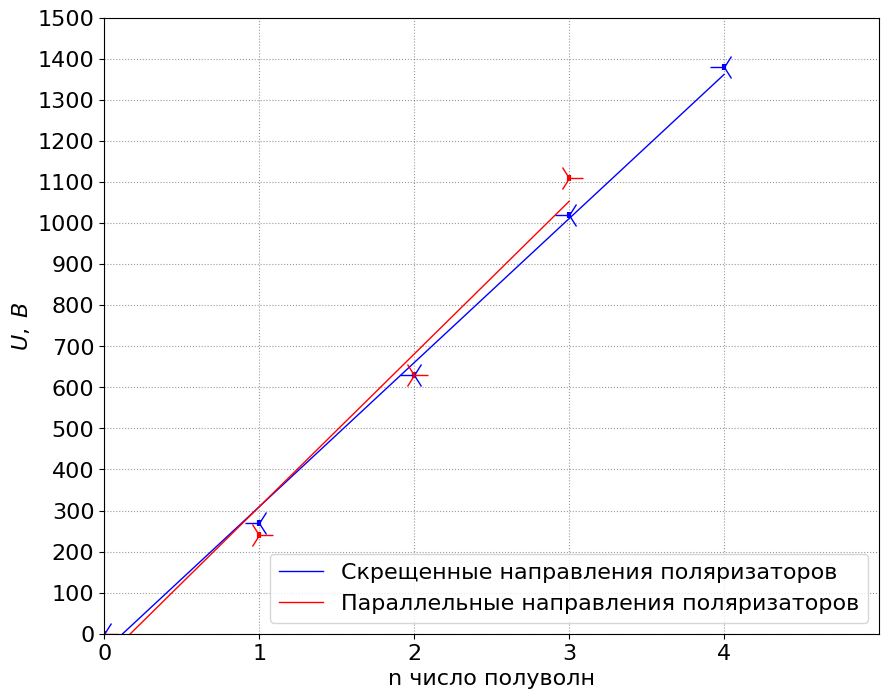

In [33]:
xMin = 0
xMax = 5

yMin = 0
yMax = 1500.01

xLabel          = r'n число полуволн'
yLabel          = r'$U, \; В$'

xMinorStep      = 0
xMajorStep      = 1

yMinorStep      = 0
yMajorStep      = 100

xTickMultiplier = 1
yTickMultiplier = 1

xPrecision      = 0
yPrecision      = 0

# Построение графика.

mpl.rcParams['font.size'] = 16

fig  = plt.figure(figsize = (10,8), dpi = 100)
axes = fig.add_subplot()

fig.set_facecolor("white")

# Заголовок

plt.xlabel(xLabel)
plt.ylabel(yLabel)

# Линии
plt.errorbar(n2, U2, yerr = sigU, xerr = 0, fmt = '3', linewidth = 3, color = 'blue', markersize=20)
plt.plot(n2, Line(n2, *popt2), linewidth = 1, color = 'blue', label = r'Скрещенные направления поляризаторов')

plt.errorbar(n3, U3, yerr = sigU, xerr = 0, fmt = '4', linewidth = 3, color = 'red', markersize=20)
plt.plot(n3, Line(n3, *popt3), linewidth = 1, color = 'red', label = r'Параллельные направления поляризаторов')

# Оформление масштабных чёрточек

if yMajorStep > 0:
    y_major_ticks = np.arange(yMin, yMax, yMajorStep)
    axes.set_yticks(y_major_ticks)

if yMinorStep > 0:
    y_minor_ticks = np.arange(yMin, yMax, yMinorStep)
    axes.set_yticks(y_minor_ticks, minor = True)

if xMajorStep > 0:
    x_major_ticks = np.arange(xMin, xMax, xMajorStep)
    axes.set_xticks(x_major_ticks)

if xMinorStep > 0:
    x_minor_ticks = np.arange(xMin, xMax, xMinorStep)
    axes.set_xticks(x_minor_ticks, minor = True)

# Пределы графика

plt.xlim([xMin, xMax])
plt.ylim([yMin, yMax])

# Форматирование чёрточек

def xTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * xTickMultiplier, prec = xPrecision).replace('.', ',')

def yTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * yTickMultiplier, prec = yPrecision).replace('.', ',')

axes.xaxis.set_major_formatter(ticker.FuncFormatter(xTickFormatter))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(yTickFormatter))

# Легенда
plt.legend(loc = 'lower right')

# Сетка
plt.grid(which='major', linestyle = ':', c = 'black', alpha = 0.4)
plt.grid(which='minor', linestyle = ':', c = 'black', alpha = 0.1)

# Вывод
plt.savefig("Графики/U_lambda.png")
plt.show()